# Decision Tree

In [57]:
%load_ext autoreload
%autoreload 2
#%reload_ext autoreload
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import geopandas
import geopy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium.plugins as plugins
import math
from math import sin, cos, sqrt, atan2, radians
from haversine import haversine
from itertools import combinations
import json
%matplotlib inline
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
import sys
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from  sklearn.metrics import precision_recall_fscore_support, precision_recall_curve
from imblearn.pipeline import make_pipeline as mp
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score
path_to_src = '..\src'
sys.path.insert(0, path_to_src)
from useful_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Data

In [2]:
df = pd.read_csv('../data/df_model.csv')
df.head()

,gps_height,longitude,latitude,basin,region,district_code,public_meeting,permit,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,status_group,pop_log,age
0,1390.0,34.94,-9.86,Lake Nyasa,Iringa,5,True,False,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,functional,4.691348,12
1,1399.0,34.70,-2.15,Lake Victoria,Mara,2,True,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,5.634790,3
2,686.0,37.46,-3.82,Pangani,Manyara,4,True,True,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,functional,5.521461,4
3,263.0,38.49,-11.16,Ruvuma / Southern Coast,Mtwara,63,True,True,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,4.060443,27
4,1300.0,31.13,-1.83,Lake Victoria,Kagera,1,True,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,5.991465,14


## Split Data

In [4]:
X = df.drop('status_group', axis=1)
y = df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Create Pipeline

In [8]:
number_selector = make_column_selector(dtype_include='number', dtype_exclude=['object', 'bool'])
string_selector = make_column_selector(dtype_include=['object', 'bool'])

preprocessing = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), string_selector),
                                        (StandardScaler(), number_selector),
                                       remainder='passthrough')
dt_pipeline = mp(preprocessing,  SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'), \
                   DecisionTreeClassifier(random_state=42))

## Fit Data

In [9]:
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027F7DD76790>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027F7DD76B80>)])),
                ('smote', SMOTE(n_jobs=-1, random_state=42)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

## Generate Predicted Data for Train and Test

In [10]:
y_hat_train = dt_pipeline.predict(X_train)
y_hat_test = dt_pipeline.predict(X_test)

## Determine Model Performance

In [11]:
print(classification_report(y_train, y_hat_train))

                         precision    recall  f1-score   support

             functional       0.99      1.00      0.99     24161
functional needs repair       0.96      0.96      0.96      3243
         non functional       1.00      0.99      0.99     17146

               accuracy                           0.99     44550
              macro avg       0.98      0.98      0.98     44550
           weighted avg       0.99      0.99      0.99     44550



In [12]:
print(classification_report(y_test, y_hat_test))

                         precision    recall  f1-score   support

             functional       0.80      0.78      0.79      8098
functional needs repair       0.34      0.41      0.37      1074
         non functional       0.76      0.75      0.76      5678

               accuracy                           0.74     14850
              macro avg       0.63      0.65      0.64     14850
           weighted avg       0.75      0.74      0.75     14850



In [30]:
test_results = classification_report(y_test, y_hat_test, output_dict=True)

In [31]:
test_results

{'functional': {'precision': 0.7998988749841992,
  'recall': 0.7814275129661645,
  'f1-score': 0.7905553126366419,
  'support': 8098},
 'functional needs repair': {'precision': 0.3366186504927976,
  'recall': 0.4134078212290503,
  'f1-score': 0.37108232344337655,
  'support': 1074},
 'non functional': {'precision': 0.7592526690391459,
  'recall': 0.7514970059880239,
  'f1-score': 0.7553549300761196,
  'support': 5678},
 'accuracy': 0.7433670033670033,
 'macro avg': {'precision': 0.6319233981720476,
  'recall': 0.6487774467277463,
  'f1-score': 0.638997522052046,
  'support': 14850},
 'weighted avg': {'precision': 0.7508515942798369,
  'recall': 0.7433670033670033,
  'f1-score': 0.7467585609482774,
  'support': 14850}}

In [33]:
test_results['functional']['recall']

0.7814275129661645

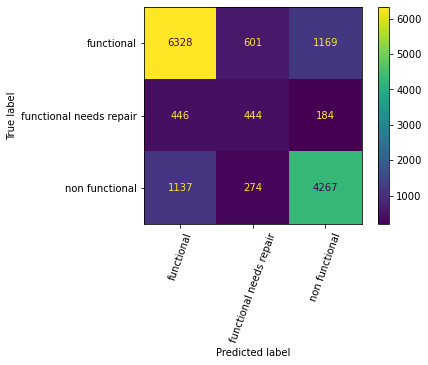

In [20]:
plot_confusion_matrix(dt_pipeline, X_test, y_test, xticks_rotation=70)  
plt.show() 

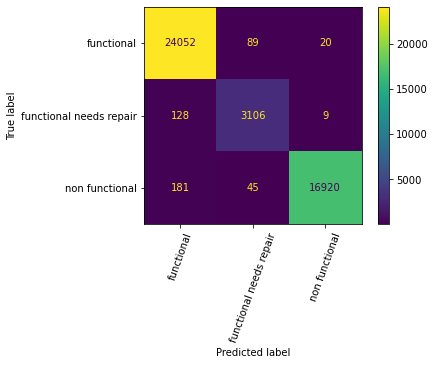

In [21]:
plot_confusion_matrix(dt_pipeline, X_train, y_train, xticks_rotation=70)  
plt.show() 

## Model Tuning

Clearly the decision tree baseline suffers from overfitting, the training performance is far superior than the test data. There are some hyperparameters that can be tuned in order to improve this situation.

- Maximum Tree Depth
- Minimum Sample Split
- Minimum Sample Leafs
- Maximum Features

### Maximum Tree Depth

In [36]:
def max_depth_search(label, score):
    max_depths = np.linspace(1, 32, 16, endpoint=True)
    md_train_results = []
    md_test_results = []
    for max_depth in max_depths:
       dt = mp(preprocessing,  SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'), \
                       DecisionTreeClassifier(max_depth=max_depth, random_state=42))
       dt.fit(X_train, y_train)
       train_pred = dt.predict(X_train)
       train_results = classification_report(y_train, train_pred, output_dict=True)
       md_train_results.append(train_results[label][score]) 
       test_pred = dt.predict(X_test)
       test_results = classification_report(y_test, test_pred, output_dict=True)
       md_test_results.append(test_results[label][score])

    plt.figure(figsize=(12,6))
    plt.plot(max_depths, md_train_results, 'b', label='Train {}'.format(score))
    plt.plot(max_depths, md_test_results, 'r', label='Test {}'.format(score))
    plt.ylabel('{} {}'.format(label, score))
    plt.xlabel('Tree depth')
    plt.legend()
    plt.show()

C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


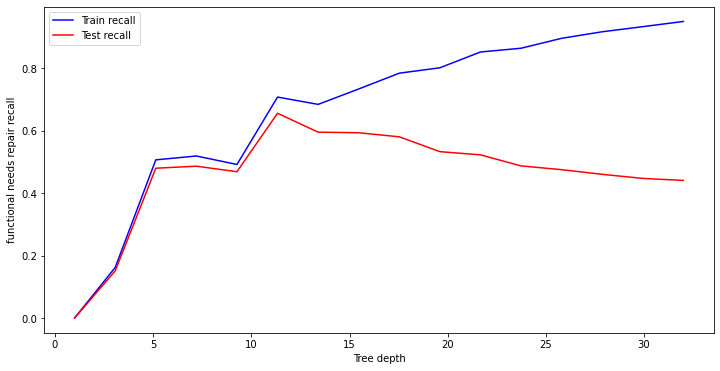

In [37]:
max_depth_search('functional needs repair', 'recall')

Focusing on functional needs repair label where I am trying to optimise recall i.e reduce the number of false negatives so pumps that need repair have the best chance of being highlighted. Maximum depth looks optimal at 12. 

## Minimum Sample Split

In [41]:
def min_samples_search(label, score):
    min_samples = np.linspace(0.1, 1.0, 10, endpoint=True)
    ms_train_results = []
    ms_test_results = []
    for min_sample in min_samples:
       dt = mp(preprocessing,  SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'), \
                       DecisionTreeClassifier(min_samples_split=min_sample, random_state=42))
       dt.fit(X_train, y_train)
       train_pred = dt.predict(X_train)
       train_results = classification_report(y_train, train_pred, output_dict=True)
       ms_train_results.append(train_results[label][score]) 
       test_pred = dt.predict(X_test)
       test_results = classification_report(y_test, test_pred, output_dict=True)
       ms_test_results.append(test_results[label][score])

    plt.figure(figsize=(12,6))
    plt.plot(min_samples, ms_train_results, 'b', label='Train {}'.format(score))
    plt.plot(min_samples, ms_test_results, 'r', label='Test {}'.format(score))
    plt.ylabel('{} {}'.format(label, score))
    plt.xlabel('Sample Split')
    plt.legend()
    plt.show()

C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andr

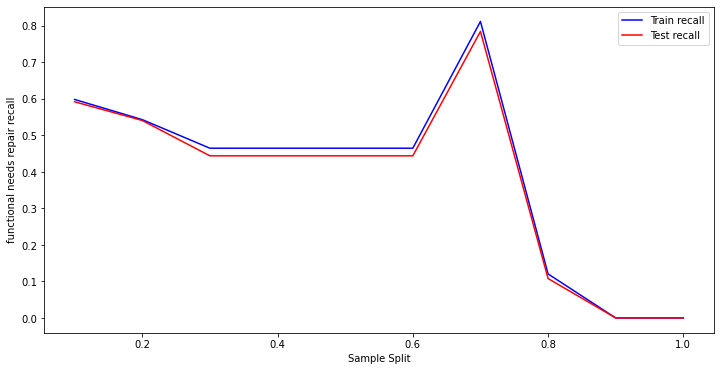

In [42]:
min_samples_search('functional needs repair', 'recall')

Optimal number here is 0.7

## Minimum Sample Leafs

In [46]:
def min_samples_leafs(label, score):
    min_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
    ml_train_results = []
    ml_test_results = []
    for min_leaf in min_leafs:
       dt = mp(preprocessing,  SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'), \
                       DecisionTreeClassifier(min_samples_leaf=min_leaf, random_state=42))
       dt.fit(X_train, y_train)
       train_pred = dt.predict(X_train)
       train_results = classification_report(y_train, train_pred, output_dict=True)
       ml_train_results.append(train_results[label][score]) 
       test_pred = dt.predict(X_test)
       test_results = classification_report(y_test, test_pred, output_dict=True)
       ml_test_results.append(test_results[label][score])

    plt.figure(figsize=(12,6))
    plt.plot(min_leafs, ml_train_results, 'b', label='Train {}'.format(score))
    plt.plot(min_leafs, ml_test_results, 'r', label='Test {}'.format(score))
    plt.ylabel('{} {}'.format(label, score))
    plt.xlabel('Sample Leafs')
    plt.legend()
    plt.show()

C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andr

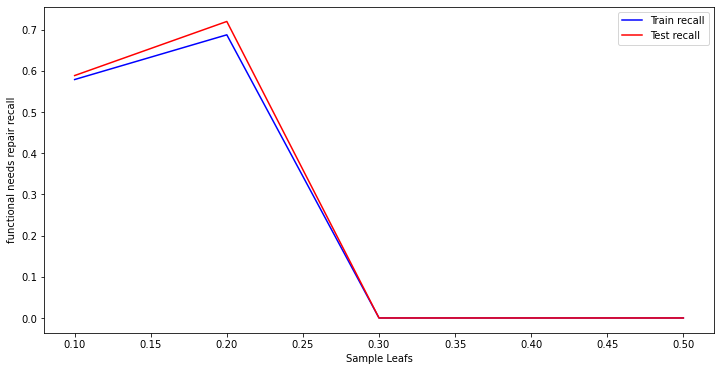

In [44]:
min_samples_leafs('functional needs repair', 'recall')

Optimal value is 0.2

## Maximum Features

In [47]:
def max_features(label, score):
    max_feat = np.array(range(1, X_train.shape[1]+1, 1))
    mf_train_results = []
    mf_test_results = []
    for max_f in max_feat:
       dt = mp(preprocessing,  SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'), \
                       DecisionTreeClassifier(max_features=max_f, random_state=42))
       dt.fit(X_train, y_train)
       train_pred = dt.predict(X_train)
       train_results = classification_report(y_train, train_pred, output_dict=True)
       mf_train_results.append(train_results[label][score]) 
       test_pred = dt.predict(X_test)
       test_results = classification_report(y_test, test_pred, output_dict=True)
       mf_test_results.append(test_results[label][score])

    plt.figure(figsize=(12,6))
    plt.plot(max_feat, mf_train_results, 'b', label='Train {}'.format(score))
    plt.plot(max_feat, mf_test_results, 'r', label='Test {}'.format(score))
    plt.ylabel('{} {}'.format(label, score))
    plt.xlabel('Features')
    plt.legend()
    plt.show()

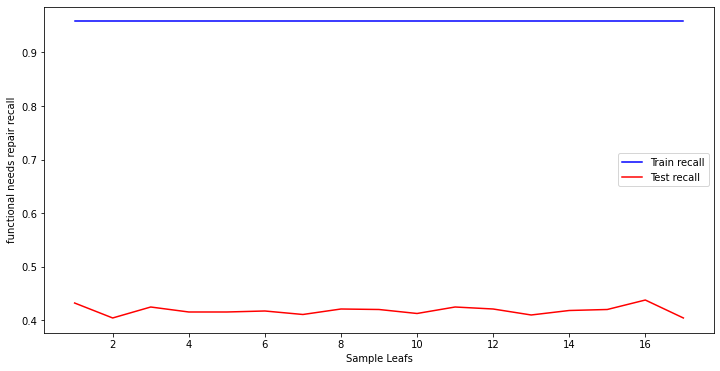

In [48]:
max_features('functional needs repair', 'recall')

16 is optimal here

## Run Model with Optimal Hyperparameters

In [49]:
dt_optimal = mp(preprocessing,  SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'), \
                   DecisionTreeClassifier(max_features=16, min_samples_leaf=0.2,\
                                          min_samples_split=0.7,max_depth=12,random_state=42))

In [50]:
dt_optimal.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027F7DD76790>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027F7DD76B80>)])),
                ('smote', SMOTE(n_jobs=-1, random_state=42)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=12, max_features=16,
                                        min_samples_leaf=0.2,
                                        min_samples_split=0.7,
                         

In [51]:
y_hat_train_opt = dt_optimal.predict(X_train)
y_hat_test_opt = dt_optimal.predict(X_test)

In [52]:
print(classification_report(y_train, y_hat_train_opt))

                         precision    recall  f1-score   support

             functional       0.67      0.32      0.43     24161
functional needs repair       0.10      0.42      0.17      3243
         non functional       0.44      0.51      0.48     17146

               accuracy                           0.40     44550
              macro avg       0.41      0.42      0.36     44550
           weighted avg       0.54      0.40      0.43     44550



In [54]:
print(classification_report(y_test, y_hat_test_opt))

                         precision    recall  f1-score   support

             functional       0.69      0.32      0.44      8098
functional needs repair       0.09      0.39      0.15      1074
         non functional       0.44      0.52      0.48      5678

               accuracy                           0.40     14850
              macro avg       0.41      0.41      0.36     14850
           weighted avg       0.55      0.40      0.43     14850



The model has not improved at all, infact probably got worse by tuning the hyperparameters. On the plus side, the overfitting of the training data has been removed

In [60]:
accuracy = accuracy_score(y_test, y_hat_test)
precision = precision_score(y_test, y_hat_test, average='weighted')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

Accuracy: 74.34%
Precision: 75.09%
